This notebook shows a synthetic example of how the _multivariate_ analysis implemented in `DIVAnd`  works.

In [1]:
using PyPlot
using LinearAlgebra
using Statistics
const plt = PyPlot # Nice for Python users

PyPlot

In [2]:
using Pkg
Pkg.develop(path="/home/ctroupin/ULiege/Tools/DIVAnd.jl")

# check with:
Pkg.status()

using DIVAnd
@show pathof(DIVAnd)

Status `~/.julia/environments/v1.8/Project.toml`
  [8f4d0f93] Conda v1.7.0
  [efc8151c] DIVAnd v2.7.7 `~/ULiege/Tools/DIVAnd.jl`
  [c43c736e] Genie v4.18.0
  [cd3eb016] HTTP v0.9.17
  [7073ff75] IJulia v1.23.3
  [682c06a0] JSON v0.21.3
  [85f8d34a] NCDatasets v0.12.4 `https://github.com/Alexander-Barth/NCDatasets.jl.git#master`
  [3725be50] PhysOcean v0.6.5
  [c3e4b0f8] Pluto v0.19.3
  [438e738f] PyCall v1.93.1
  [d330b81b] PyPlot v2.10.0
  [ade2ca70] Dates
  [10745b16] Statistics
pathof(DIVAnd) = "/home/ctroupin/ULiege/Tools/DIVAnd.jl/src/DIVAnd.jl"


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


"/home/ctroupin/ULiege/Tools/DIVAnd.jl/src/DIVAnd.jl"

## Create synthetic observations

In [34]:
ND=159
NX=200
NY=250
NV=2

# function to interpolate
fun(x,y,v) = 2*(sin.(6x) * cos.(6y))*(1.5-v) .+ (v.-1.0) .* x .* y

fun (generic function with 1 method)

### Observations
The 2 first coordinates `x` and `y` can be considered as the _spatial_ coordinates.     
The 3rd coordinate `v` represent the variable that has been measured: 
- v[i] == __1__ means that at (x[i], y[i]), it is the _first_ variable that has been measured (for example, temperature).
- v[i] == __2__ means that the 2nd variable was measured at (x[i], y[i]).

In this simple example we will work with only 2 pseudo-variables, hence `v` only takes the values __1__ or __2__.

In [35]:
x = 0.5 .+ 0.25 .*randn(ND);
y = 0.5 .+ 0.25 .* randn(ND);
v = mod.(rand(Int,ND),2).+1

# The locations of the observations are moved either to the left or to the right, 
# according to the variable that was measured.

x[v.>1.5] .+= 0.2
x[v.<1.5] .+= -0.2

# Observations
f = fun.(x,y,v)+0.2*randn(ND)

# Reference field
fref = fun.(xi,yi,vi);

### Mask, grid and metrics
Note that the grid has a 3rd dimension `vi`!

In [36]:
# All points are valid points, except a rectangular area.
mask = trues(size(xi));
mask[10:30,20:50,:].=false

# final grid
xi,yi,vi = ndgrid(range(0,stop=1,length=NX),range(0,stop=1,length=NY),1:2);

pm = ones(size(xi)) / (xi[2,1,1]-xi[1,1,1]);
pn = ones(size(xi)) / (yi[1,2,1]-yi[1,1,1]);
pv = ones(size(xi)) / (vi[1,1,2]-vi[1,1,1]);

## Perform simple analysis
### Parameters
Again note that the correlation length has 3 components and that the 3rd is set to __0__.

In [37]:
len = 0.2
epsilon2 = 1.0;
@time fi, s = DIVAndrun(mask, (pm,pn,pv), (xi,yi,vi), (x,y,v), f, (len,len,0.0), epsilon2);

  1.066443 seconds (3.95 k allocations: 1.293 GiB, 1.68% gc time)


### Plot the interpolated field for each _variable_ and the corresponding observations

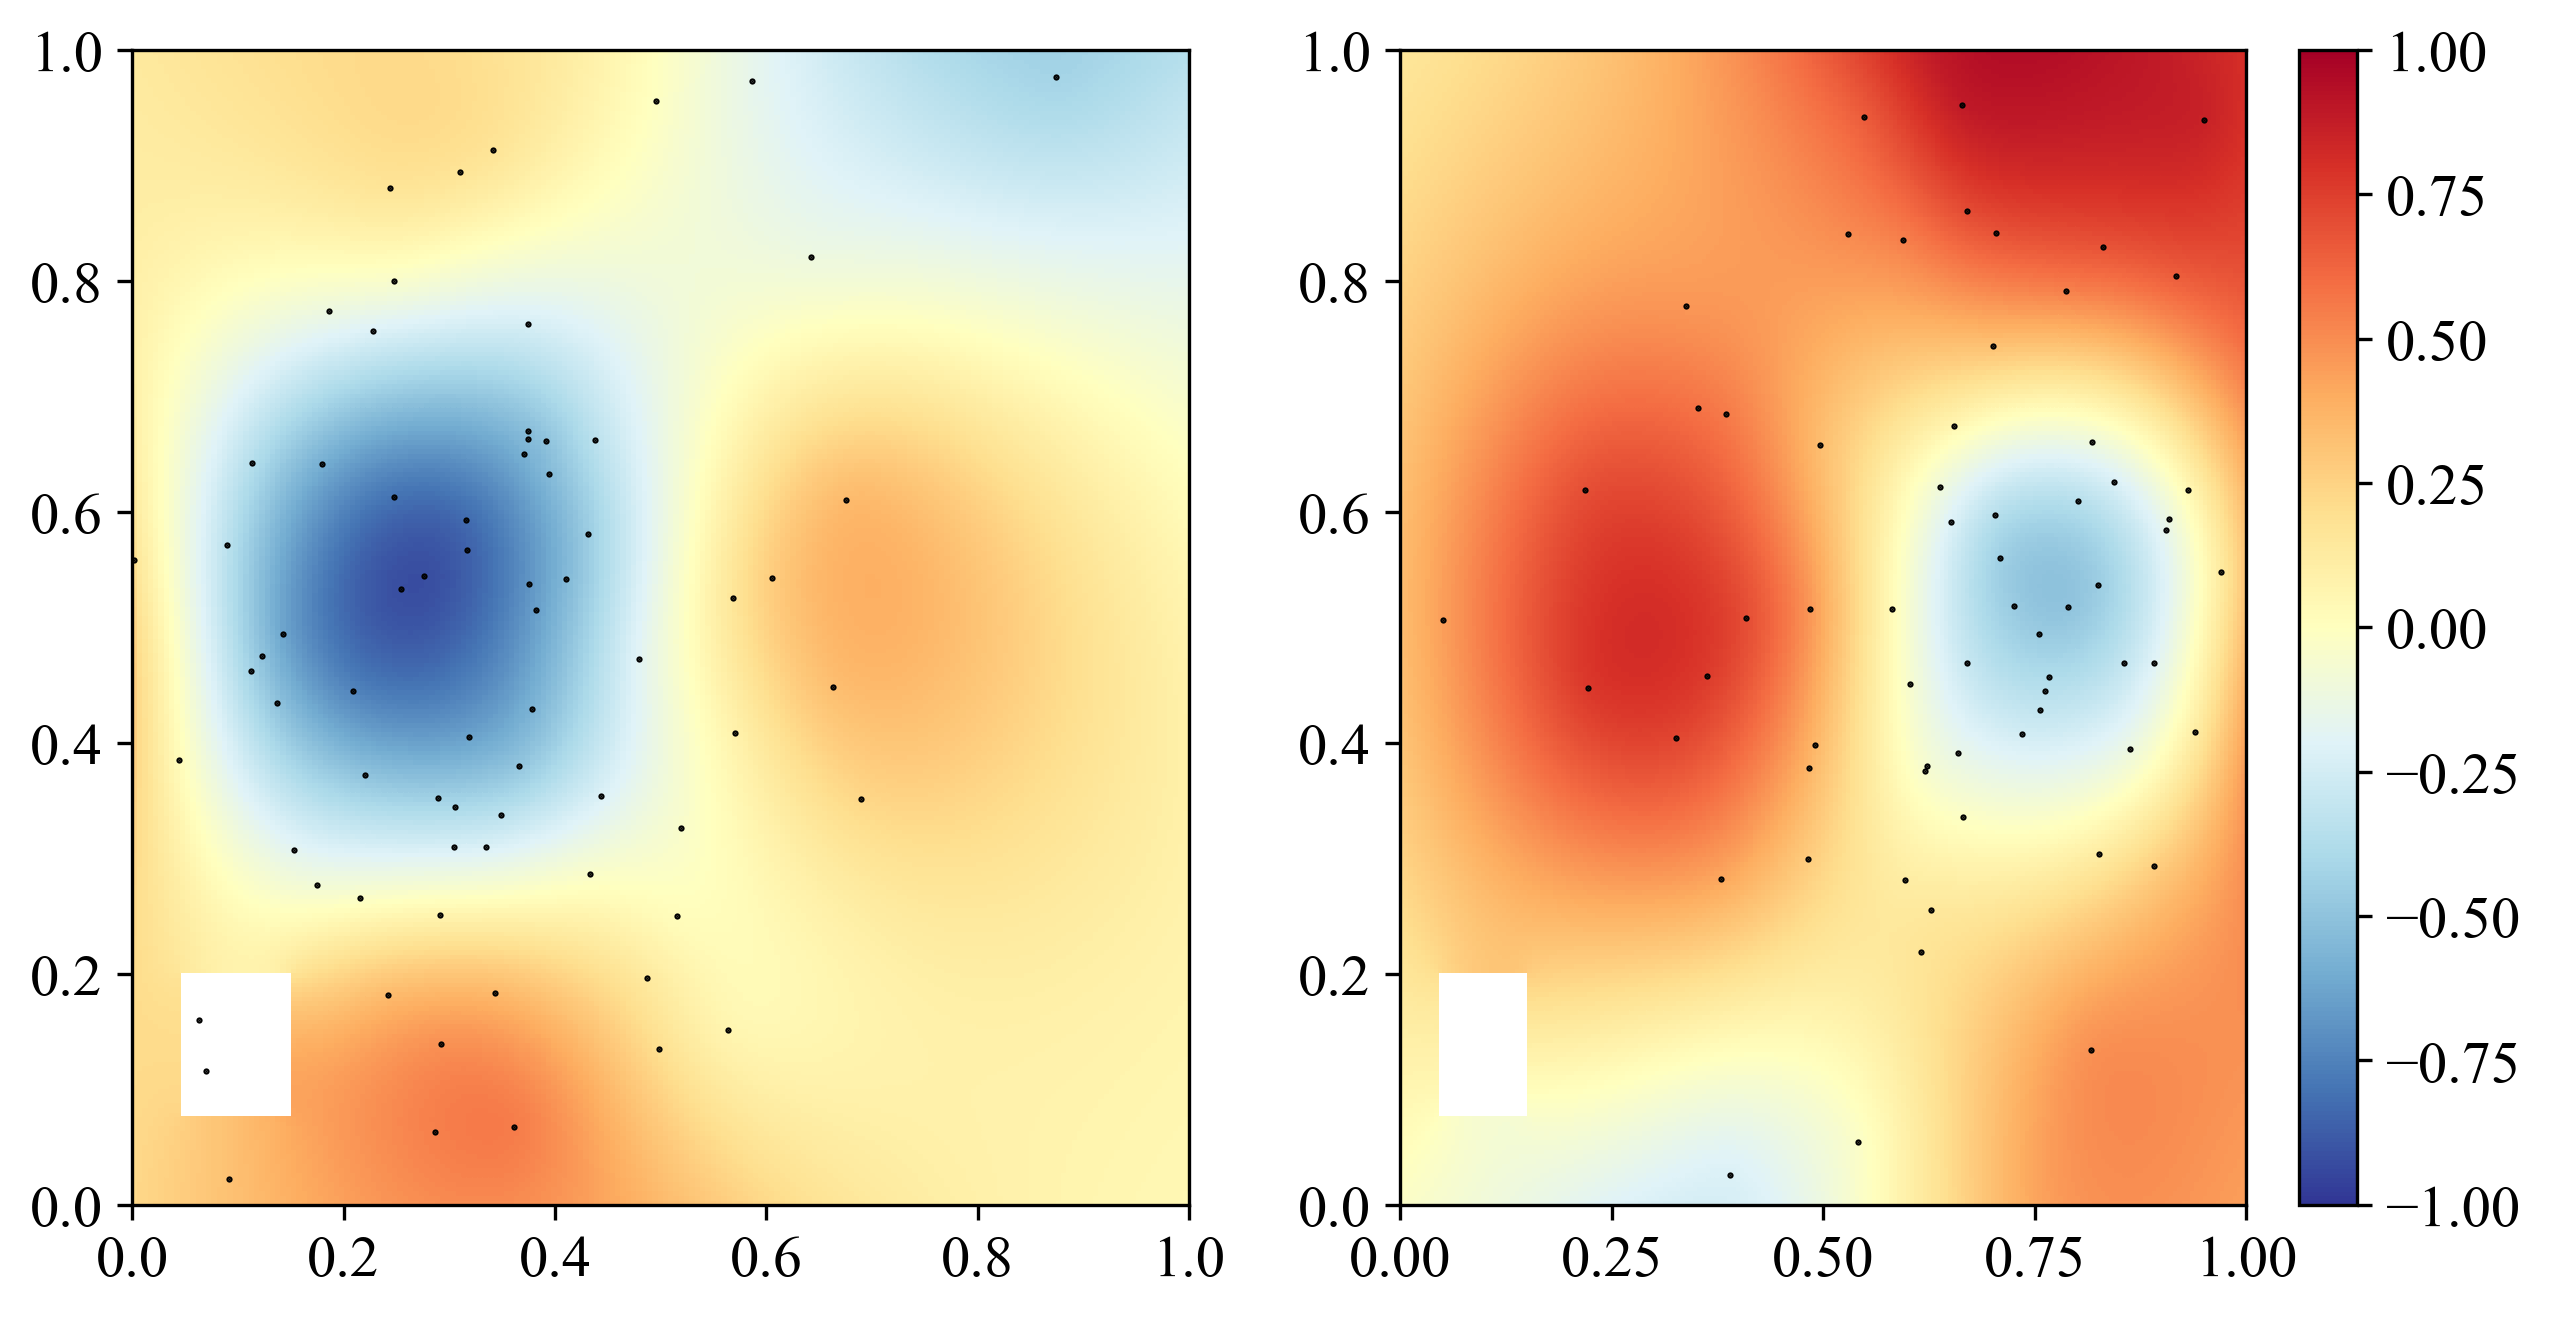

PyObject <matplotlib.colorbar.Colorbar object at 0x7f2ab0c1dc90>

In [38]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax.pcolor(xi[:,:,1],yi[:,:,1],fi[:,:,1], vmin=-1., vmax=1., cmap=plt.cm.RdYlBu_r)
ax.plot(x[v.<1.5], y[v.<1.5], "ko", ms=.5)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax = plt.subplot(122)
pcm = ax.pcolor(xi[:,:,2],yi[:,:,2],fi[:,:,2], vmin=-1., vmax=1., cmap=plt.cm.RdYlBu_r)
ax.plot(x[v.>1.5],y[v.>1.5], "ko", ms=.5)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.colorbar(pcm)

## Perform multivariate analysis
### Transform correlation length to matrix

In [39]:
len = 0.2*ones(Float64,size(mask));

### Analysis
Check the function docstring to know more about the output of a `DIVAnd_multivarEOF` execution.

In [40]:
@time fim, s, eof, eofamplitudes, emap, emapm = 
DIVAnd_multivarEOF(mask,(pm,pn,pv),(xi,yi,vi),(x,y,v),f,(len,len,0.0 .*len),epsilon2);

 16.846067 seconds (18.84 M allocations: 10.431 GiB, 3.32% gc time, 56.31% compilation time)


### Plot the 2 variables

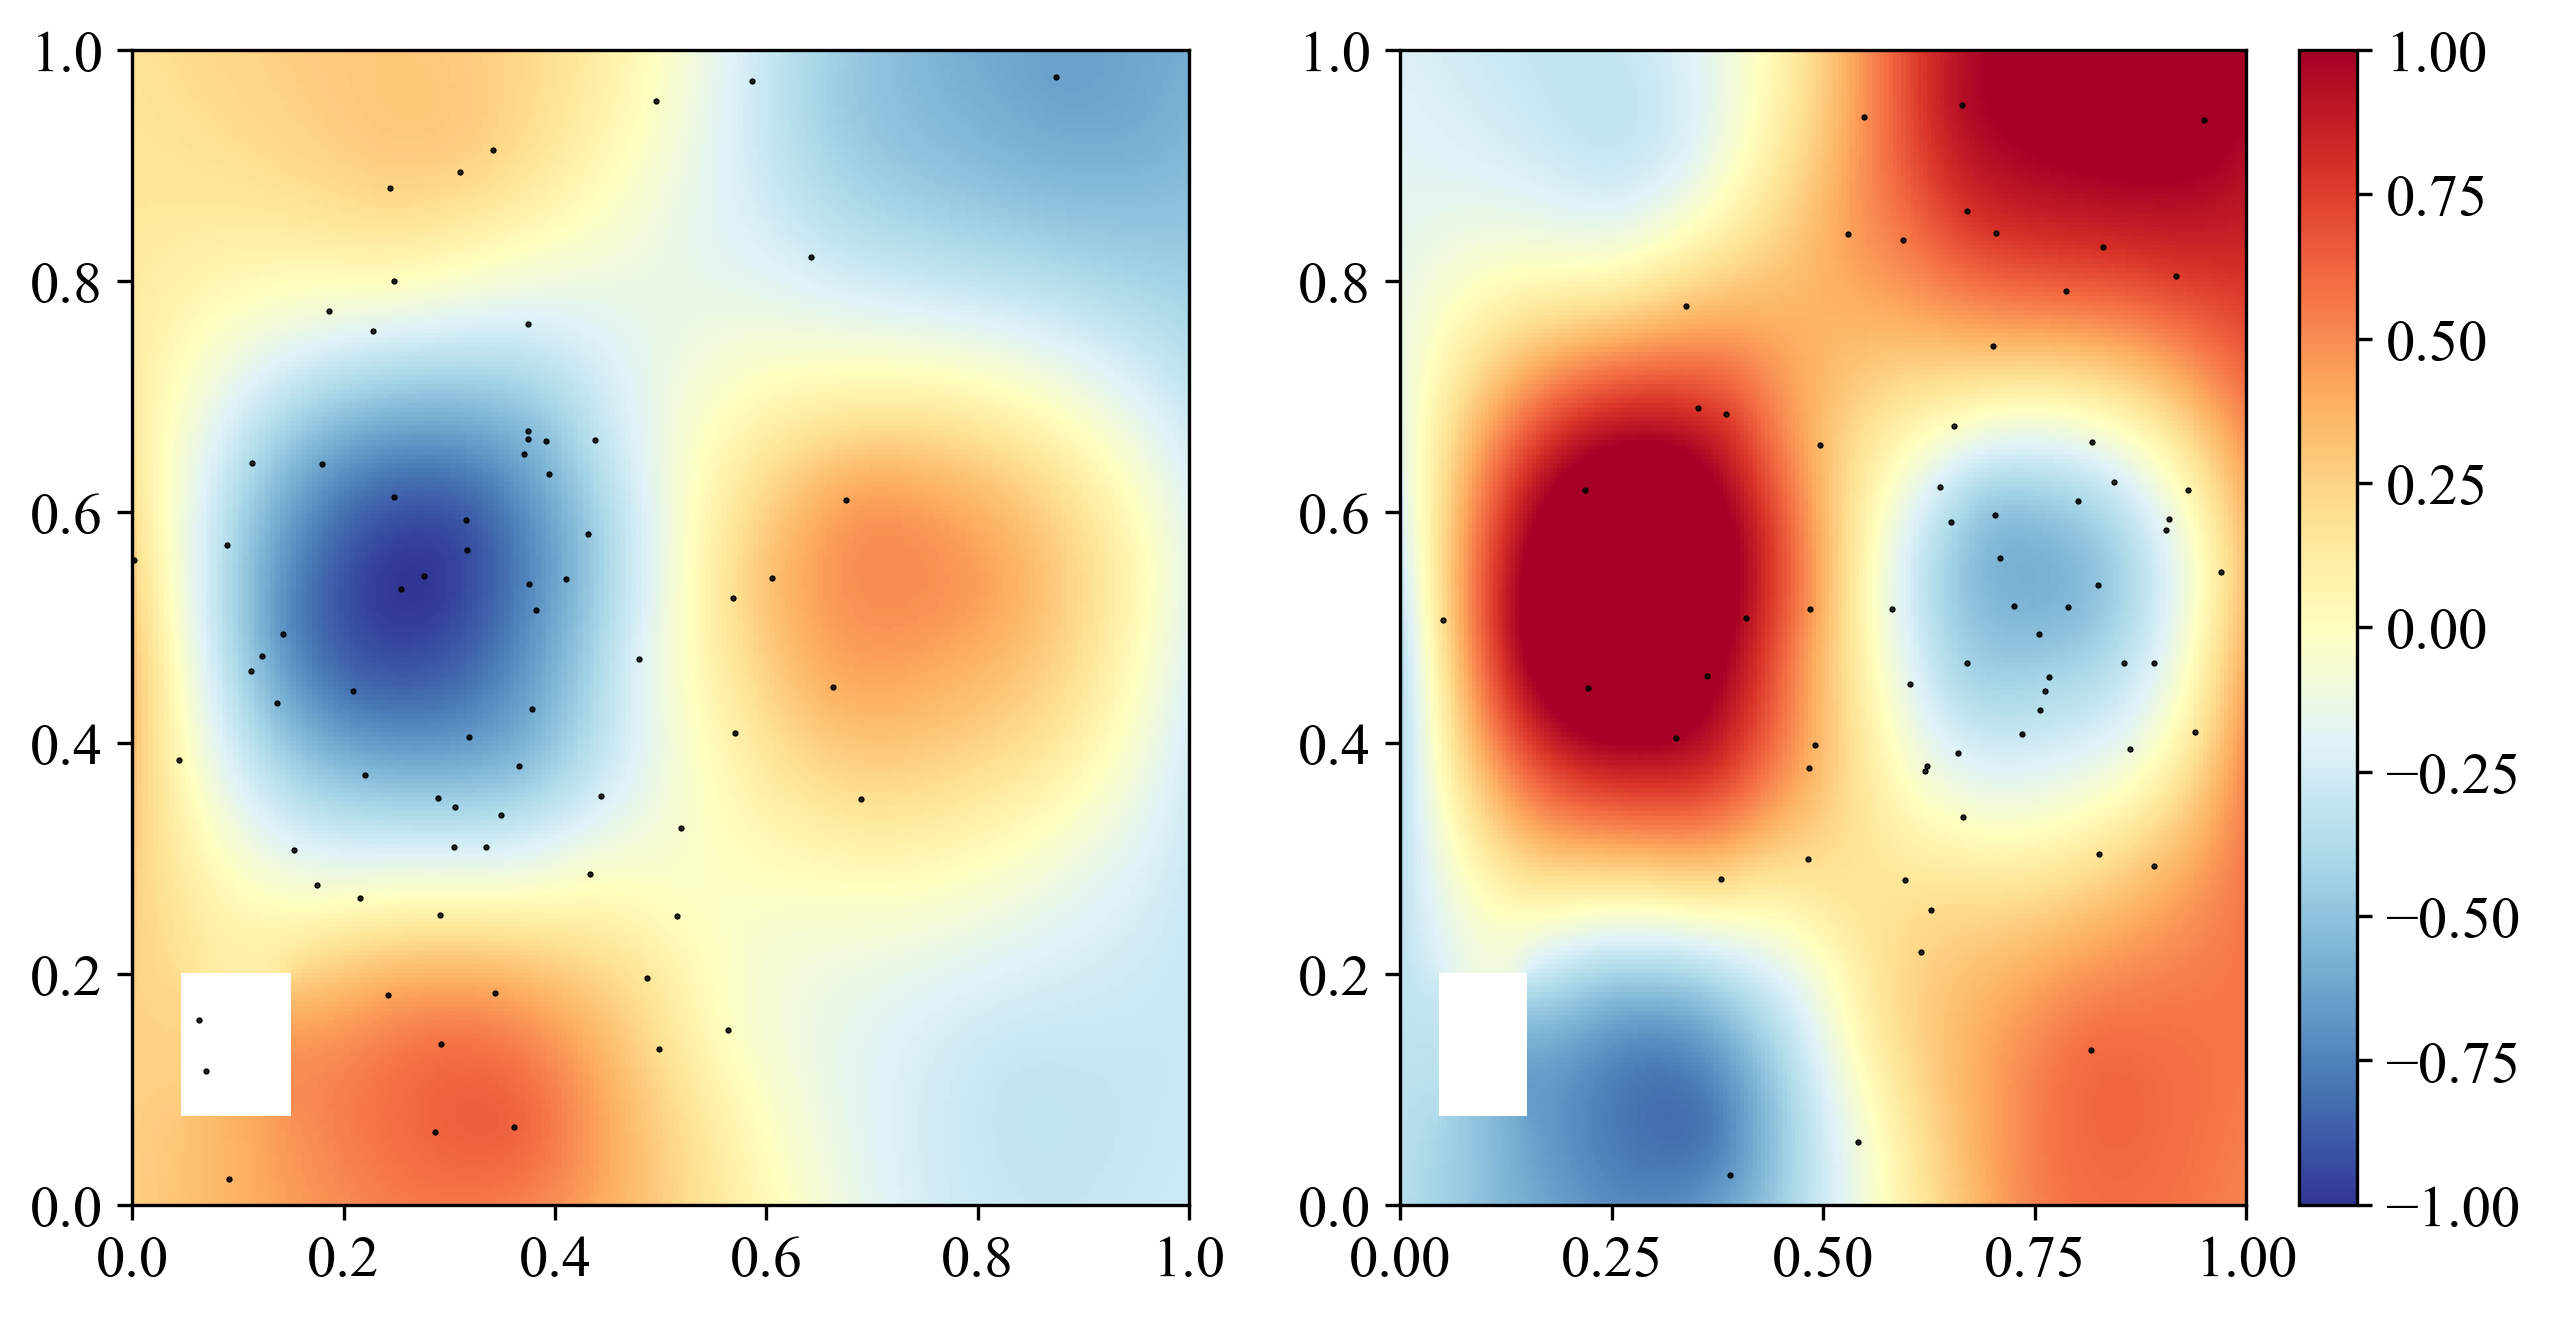

PyObject <matplotlib.colorbar.Colorbar object at 0x7f2abfad2690>

In [41]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax.pcolor(xi[:,:,1],yi[:,:,1],fim[:,:,1], vmin=-1., vmax=1., cmap=plt.cm.RdYlBu_r)
ax.plot(x[v.<1.5], y[v.<1.5], "ko", ms=.5)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax = plt.subplot(122)
pcm = ax.pcolor(xi[:,:,2],yi[:,:,2],fim[:,:,2], vmin=-1., vmax=1., cmap=plt.cm.RdYlBu_r)
ax.plot(x[v.>1.5],y[v.>1.5], "ko", ms=.5)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.colorbar(pcm)

### Additional plots
#### Difference between the 2 analysis

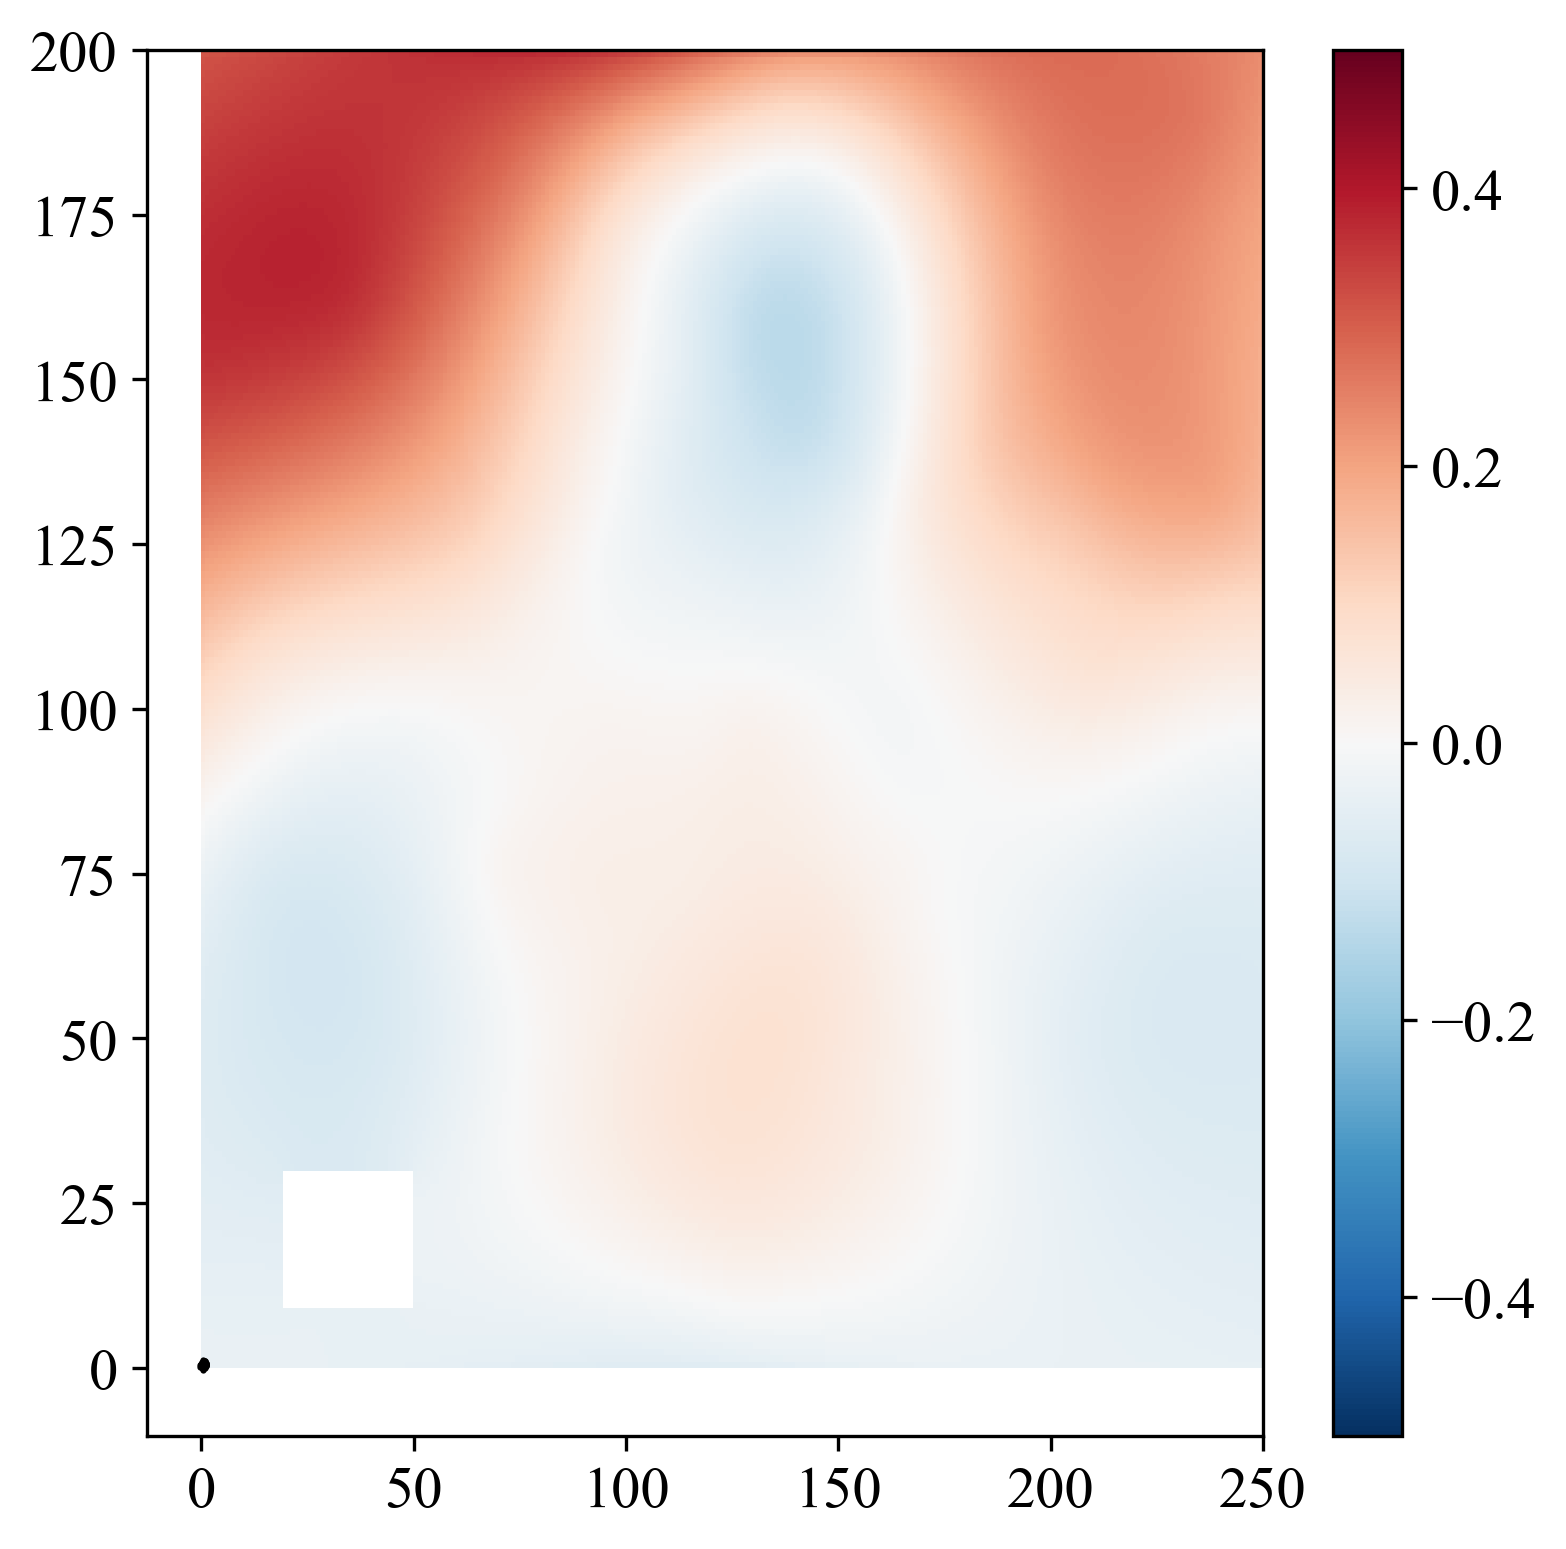

In [58]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
diff = ax.pcolor(fi[:,:,1] .- fim[:,:,1], vmin=-0.5, vmax=0.5, cmap=PyPlot.cm.RdBu_r)
ax.plot(x, y, "ko", ms=.5)
cb = plt.colorbar(diff)
plt.show()

#### EOF amplitutes

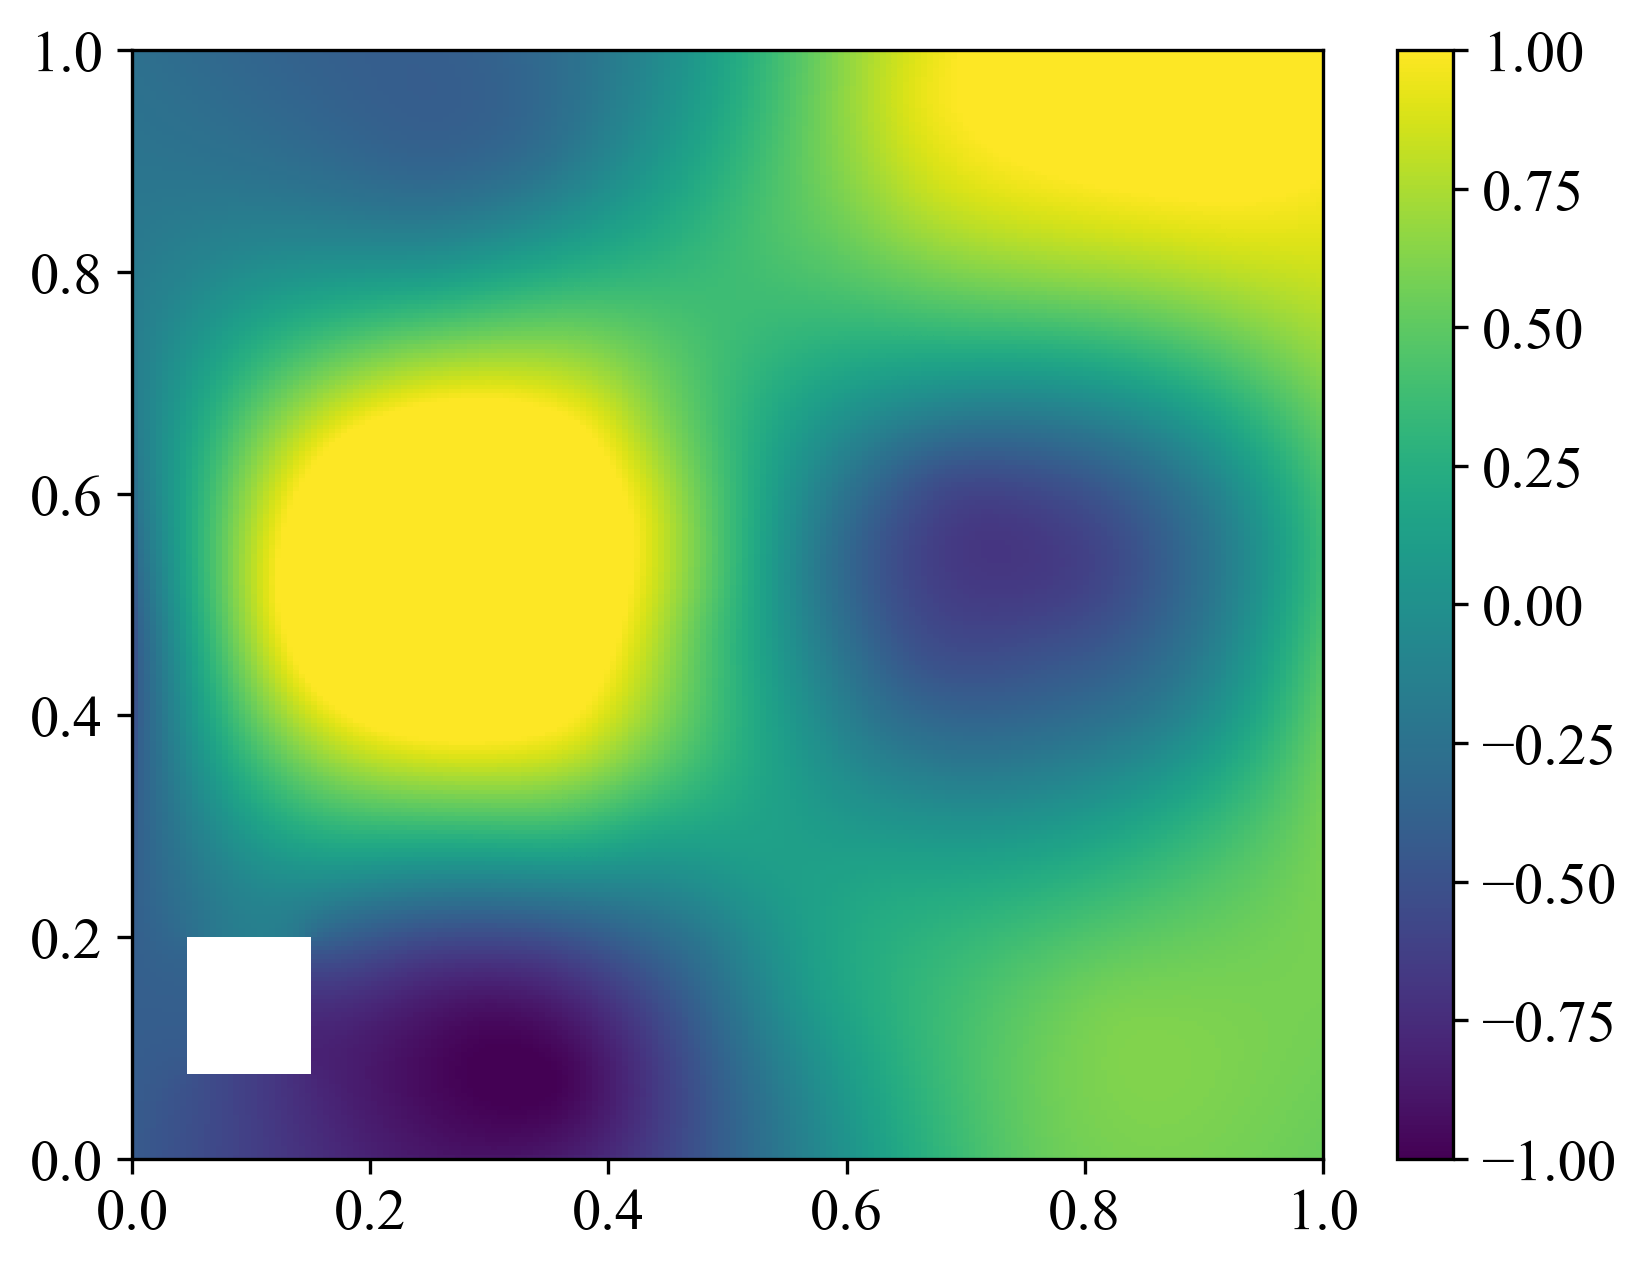

In [46]:
pcolor(xi[:,:,1],yi[:,:,1],eofamplitudes)
colorbar()
clim(-1,1)

#### The 2 EOFSs

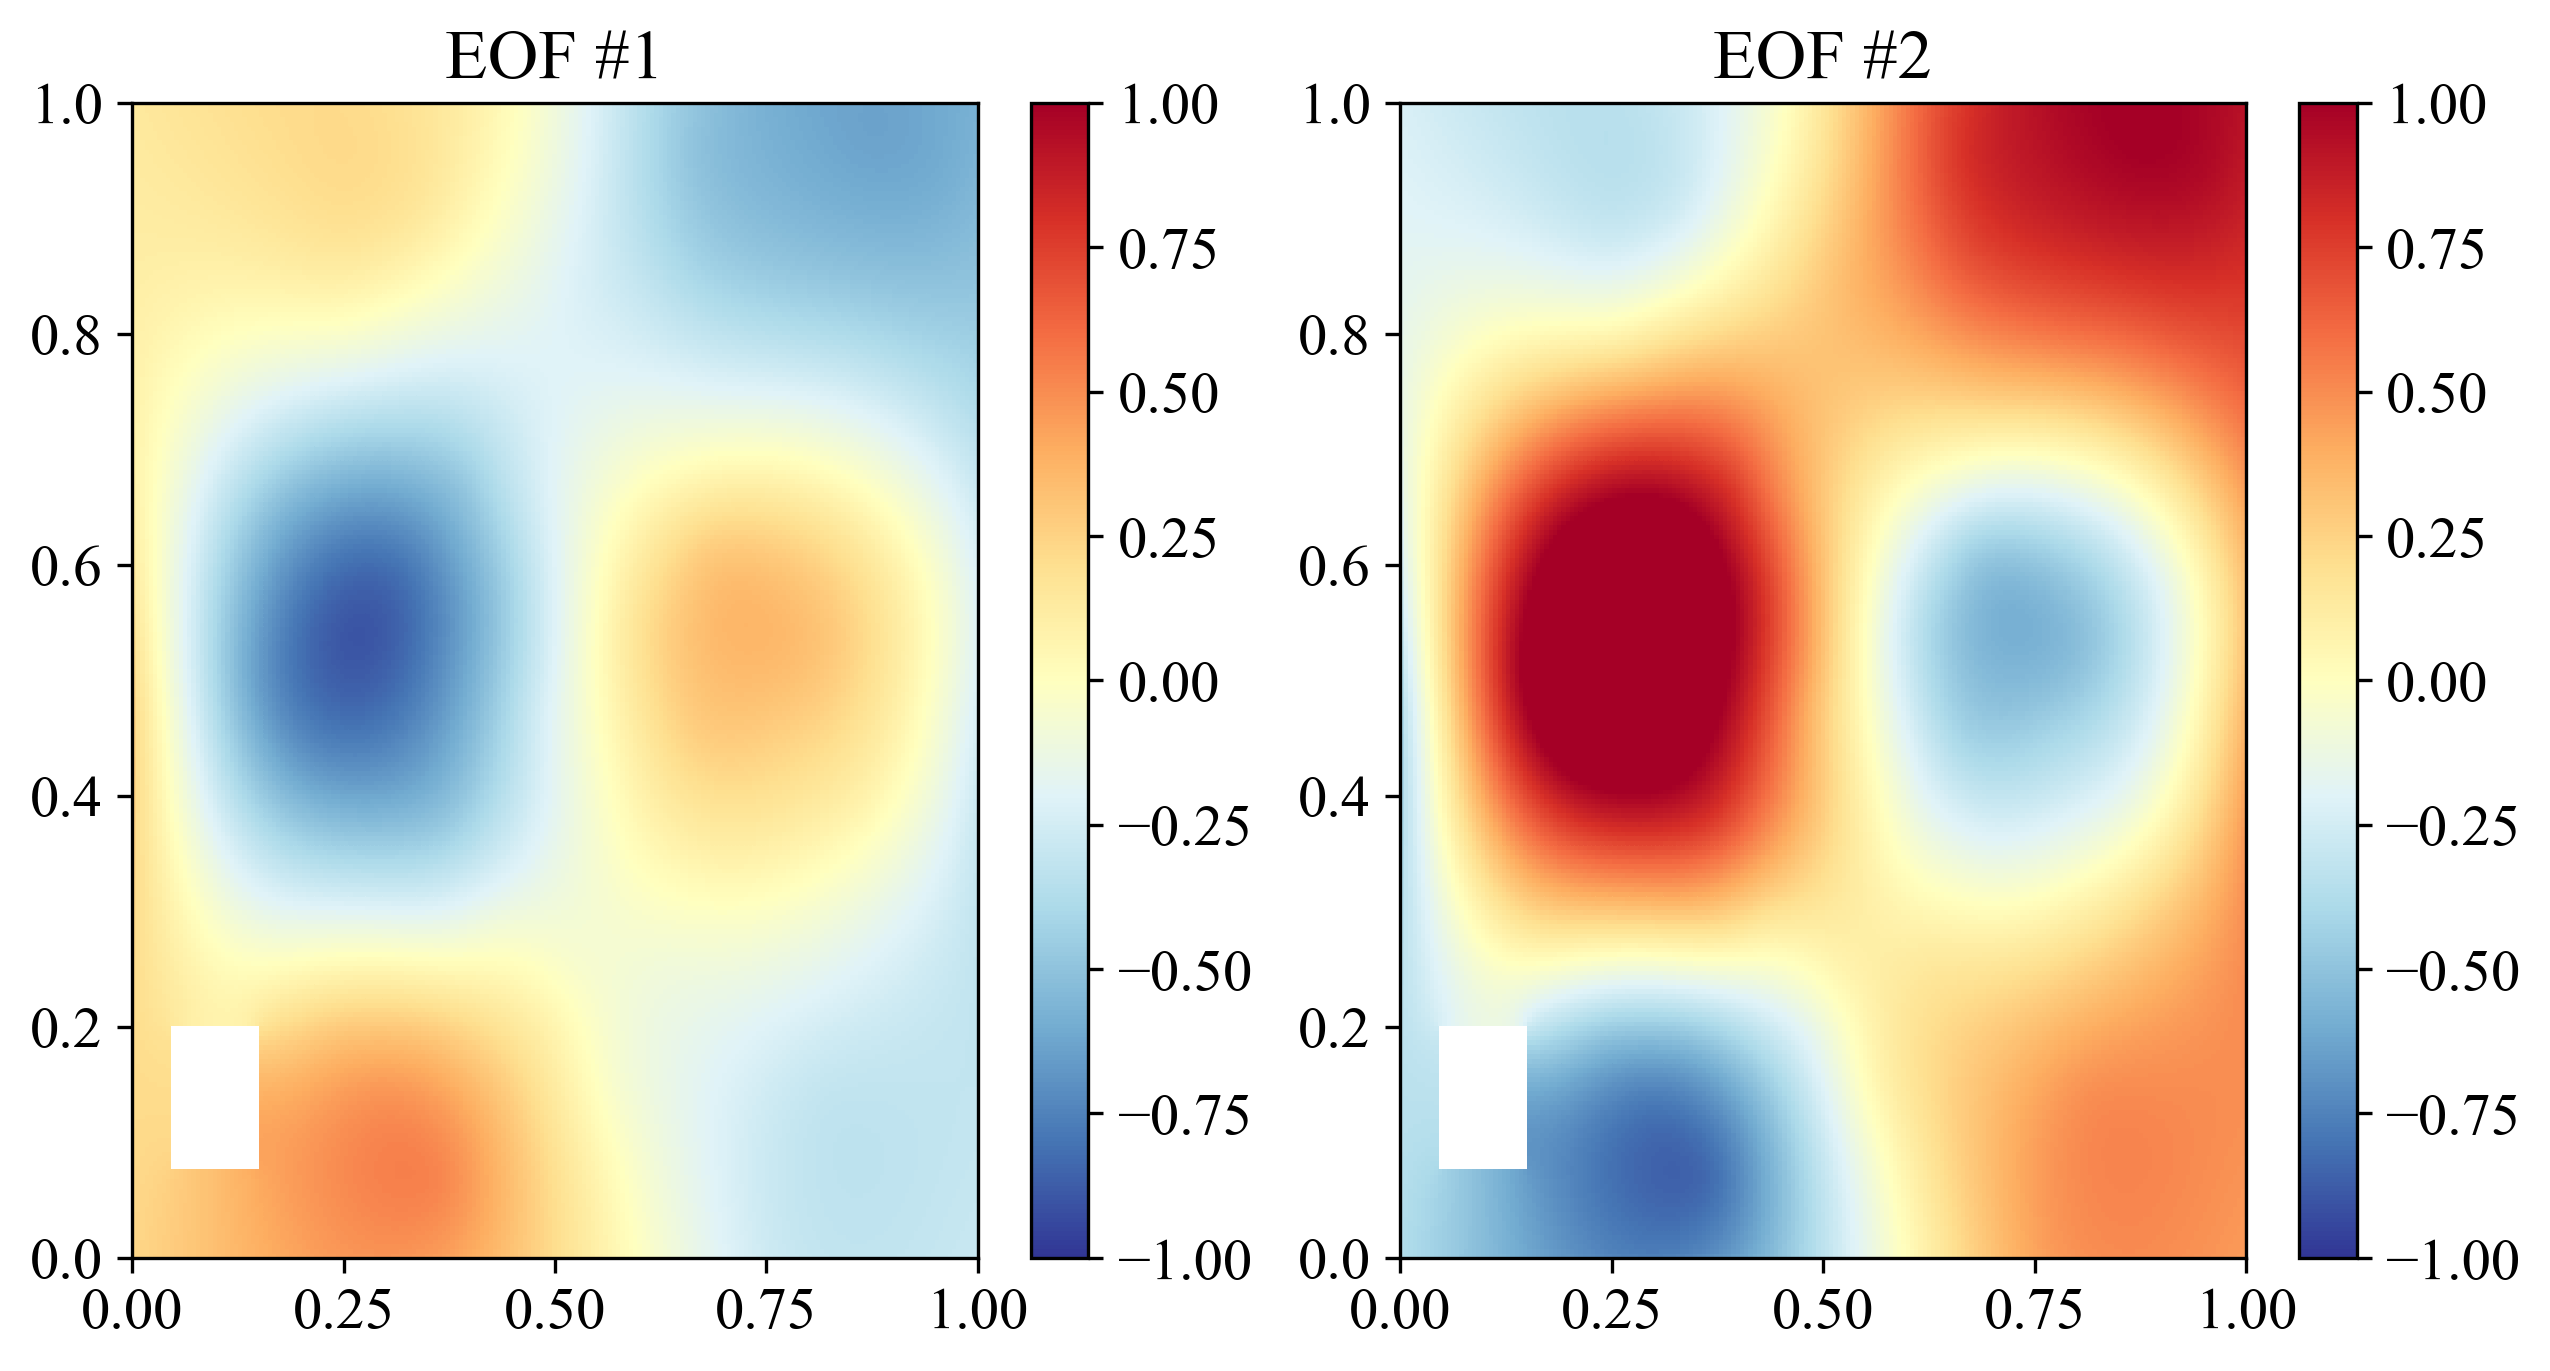

PyObject Text(0.5, 1, 'EOF #2')

In [52]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
pcm = ax.pcolor(xi[:,:,1],yi[:,:,1], eofamplitudes*eof[1], vmin=-1., vmax=1., cmap=plt.cm.RdYlBu_r)
plt.colorbar(pcm)
ax.set_title("EOF #1")

ax = plt.subplot(122)
pcm2 = ax.pcolor(xi[:,:,1],yi[:,:,1], eofamplitudes*eof[2], vmin=-1., vmax=1., cmap=plt.cm.RdYlBu_r)
plt.colorbar(pcm2)
ax.set_title("EOF #2")

#### Reference field

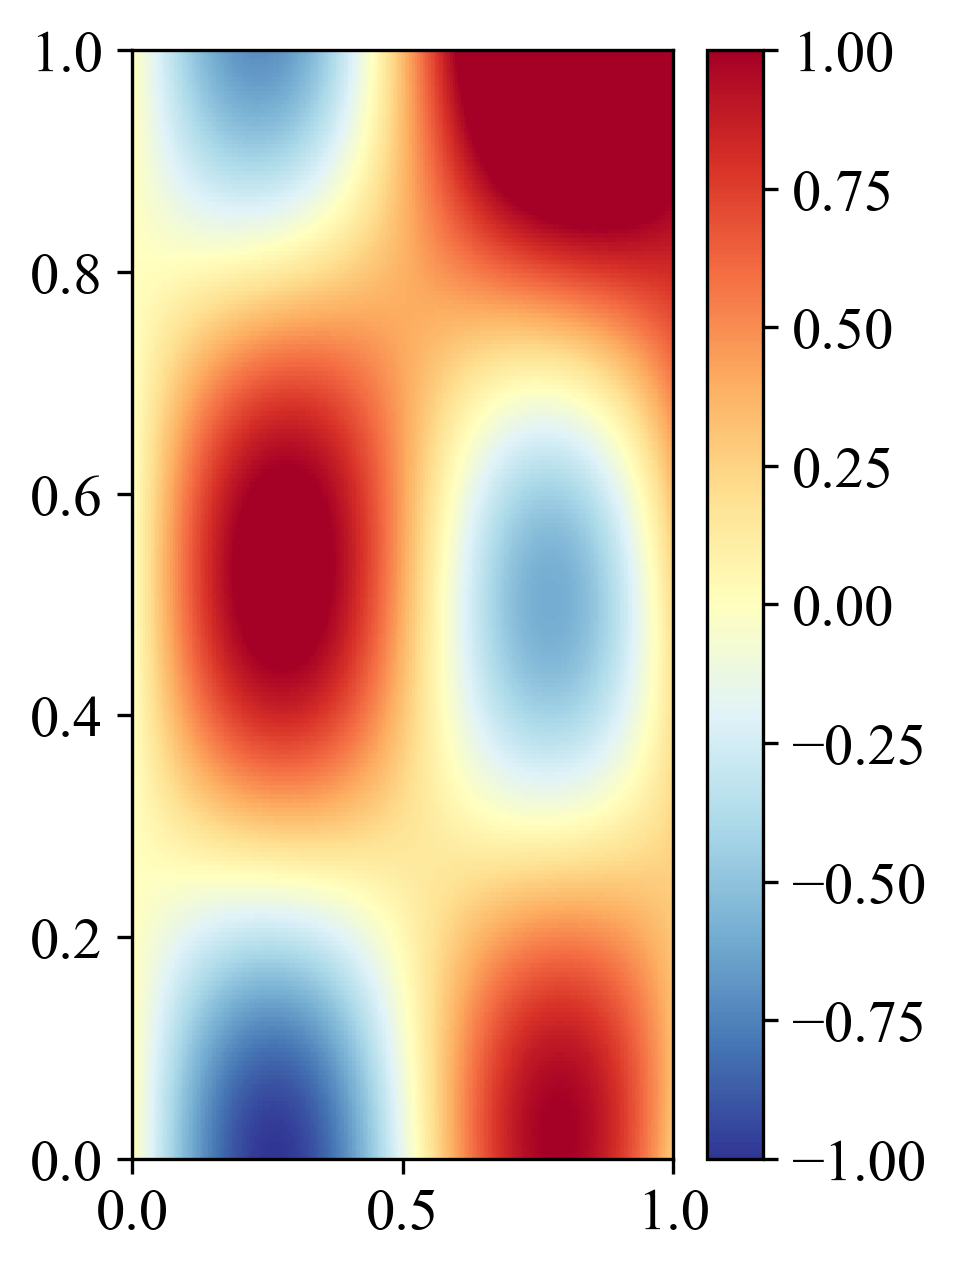

PyObject <matplotlib.colorbar.Colorbar object at 0x7f2aa56ff810>

In [73]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(121)
pcm = ax.pcolor(xi[:,:,2],yi[:,:,2],fref[:,:,2], vmin=-1., vmax=1., cmap=plt.cm.RdYlBu_r)
#scatter(x[v.>1.5],y[v.>1.5])
xlim(0,1)
ylim(0,1)
plt.colorbar(pcm)

In [59]:
using Statistics
function nanvar(f)
    return var(f[.!isnan.(f)])
end
@show nanvar(fi-fref), nanvar(fim-fref)
@show nanvar(eofamplitudes*eof[1]-fref[:,:,1])
@show nanvar(fim[:,:,1]-fref[:,:,1])
@show nanvar(eofamplitudes*eof[2]-fref[:,:,2])
@show nanvar(fim[:,:,2]-fref[:,:,2])

(nanvar(fi - fref), nanvar(fim - fref)) = (0.1033593681742495, 0.04655910813500165)
nanvar(eofamplitudes * eof[1] - fref[:, :, 1]) = 0.07843426304989343
nanvar(fim[:, :, 1] - fref[:, :, 1]) = 0.06512841173021926
nanvar(eofamplitudes * eof[2] - fref[:, :, 2]) = 0.03381835769545964
nanvar(fim[:, :, 2] - fref[:, :, 2]) = 0.026273629750278166


0.026273629750278166

In [60]:
eof

2-element Vector{Float64}:
 -0.5315046340147084
  0.8470553842700552

In [61]:
extrema(fref)

(-0.9999956276918577, 1.7600673347451958)

In [62]:
extrema(f)

(-1.1544992134445642, 1.3542550219797775)

In [67]:
extrema(fi[mask])

(-0.923388325065181, 0.9490448819315034)

In [68]:
extrema(fim[mask])

(-0.9986310574921217, 1.434277243866509)

In [71]:
extrema(eofamplitudes[mask[:,:,1]].*eof[1])

(-0.9006778815721173, 0.5402791901295838)

In [72]:
extrema(eofamplitudes[mask[:,:,1]].*eof[2])

(-0.861039335727907, 1.4354043224719968)

In [ ]:
pcolor(xi[:,:,1],yi[:,:,1],emap[:,:,1])
clim(0,1)
scatter(x[v.<1.5],y[v.<1.5])
xlim(0,1)
ylim(0,1)
clim(0,1)
colorbar()

In [ ]:
pcolor(xi[:,:,2],yi[:,:,2],emap[:,:,2])
clim(0,1)
scatter(x[v.>1.5],y[v.>1.5])
xlim(0,1)
ylim(0,1)
clim(0,1)
colorbar()

In [ ]:
pcolor(xi[:,:,1],yi[:,:,1],emapm[:,:,1])
clim(0,1)
scatter(x[v.<1.5],y[v.<1.5])
xlim(0,1)
ylim(0,1)
clim(0,1)
colorbar()

In [ ]:
var(emap-emapm),var(emap)

In [ ]:
pcolor(xi[:,:,1],yi[:,:,1],emap[:,:,1]-emapm[:,:,1]),colorbar()

In [ ]:
pcolor(xi[:,:,2],yi[:,:,2],emap[:,:,2]-emapm[:,:,2]),colorbar()